In [1]:
# import packages
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import Adam
import torchvision
from torchvision import transforms
import time
from tqdm import tqdm

## 1. Prepare the Data

In [2]:
# define train and validation data path
train_data_path = 'datasets/tomato_custom/train'
test_data_path = 'datasets/tomato_custom/val'

In [3]:
# define the hyperparameters
batch_size = 64
train_split = 0.90
val_split = 1 -  train_split

In [4]:
# define the transformations done on the dataset
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4518, 0.4638, 0.4181],
    std=[0.1836, 0.1602, 0.1991])
])

In [5]:
# load the initial data
initial_data = torchvision.datasets.ImageFolder(
    root=train_data_path, 
    transform=transform
)

test_data = torchvision.datasets.ImageFolder(
    root=test_data_path, 
    transform=transform
)

In [6]:
print(len(initial_data))

6691


In [7]:
# split the initial data into train and test sets
len_init = len(initial_data) - 1
train_len = int(len_init * train_split)
val_len = int(len_init * val_split) + 2
train_data, val_data = random_split(initial_data, [train_len, val_len], generator=torch.Generator().manual_seed(42))

In [8]:
# load the train, val and test sets

train_loader = DataLoader(
  train_data, 
  batch_size=batch_size, 
  shuffle=False
)

test_loader = DataLoader(
  test_data, 
  batch_size=batch_size, 
  shuffle=False
)

val_loader = DataLoader(
  val_data, 
  batch_size=batch_size, 
  shuffle=False
)

In [9]:
print(len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset))

6021 670 806


In [10]:
# compute steps per epoch for training and validation set
train_steps = len(train_loader.dataset) // batch_size
val_steps = len(val_loader.dataset) // batch_size

## 2. Define the model

In [11]:
class TomatoDiseaseCNN(nn.Module):
    '''
        Convolutional Neural Network for tomato disease classification
    '''
    def __init__(self, in_channels=3, num_classes=10):
        super(TomatoDiseaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(128*8*8, 256)
        self.act4 = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes)
        self.act5 = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)
        x = x.view(-1, 128*8*8)
        x = self.fc1(x)
        x = self.act4(x)
        x = self.fc2(x)
        x = self.act5(x)
        return x

In [12]:
# choose the device on which we can train the mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TomatoDiseaseCNN(3, 10).to(device)
# define the loss and the optimier
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

## 3. Train the model

In [13]:
# define train model 
def train_model(model, optimizer, loss_fn, train_loader, val_loader, epochs=10, device=device):
    # initialize the dict to store the history of the model
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }
    for epoch in range(epochs):
        # set the model in training mode
        model.train()
        # initialise the training and validation loss
        train_loss, val_loss = 0, 0
        # initialize numbers of correct train and correct validation
        correct_train, correct_val = 0, 0
        for data, target in tqdm(train_loader,  ascii ="  ...="):
            data = data.to(device)
            target = target.to(device)
            # set parameters gradients to zero
            optimizer.zero_grad()
            # forward pass
            output = model(data)
            # compute the loss
            loss = loss_fn(output, target)
            # compute the loss gradients w. r. t. parameters
            loss.backward()
            # update the parameters
            optimizer.step()
            train_loss += loss
            # _, correct = output.max(1)
            # correct_train += (correct == target).sum()
            correct_train +=(output.argmax(1) ==target).type(torch.float).sum().item()
        with torch.no_grad():
            # set the model in evaluation mode
            model.eval()
            for data, target in val_loader:
                data = data.to(device)
                target = target.to(device)
                # forward from validation data
                output = model(data)
                loss = loss_fn(output, target)
                val_loss += loss
                correct_val +=(output.argmax(1) ==target).type(torch.float).sum().item()
        # compute the average of traning and validation loss
        train_loss_avg = train_loss / train_steps
        # training_loss /= len(train_loader)
        val_loss_avg = val_loss / val_steps
        # valid_loss /= len(val_loader)

        # compute the accuracy of training and validation set
        # calculate the training and validation accuracy
        correct_train = correct_train / len(train_loader.dataset)
        correct_val = correct_val / len(val_loader.dataset)
        # update our training history
        history["train_loss"].append(train_loss_avg.cpu().detach().numpy())
        history["train_acc"].append(correct_train)
        history["val_loss"].append(val_loss_avg.cpu().detach().numpy())
        history["val_acc"].append(correct_val)

        # print the model training and validation information
        print("Epoch: {}/{}".format(epoch + 1, epochs))
        print("train loss: {:.6f} - train accuracy: {:.4f}".format(train_loss_avg, correct_train))
        print("val loss: {:.6f} - val accuracy: {:.4f}".format(val_loss_avg, correct_val))
    return history

In [14]:
# train and check the time of training
start_time = time.time()
history = train_model(model, optimizer, criterion, train_loader, val_loader, 80)
end_time = time.time()
print("The model took {:.2f}s for training : ".format(end_time - start_time))

  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 1/80
train loss: 2.076870 - train accuracy: 0.4031
val loss: 2.208071 - val accuracy: 0.4582


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 2/80
train loss: 1.886419 - train accuracy: 0.5946
val loss: 2.021884 - val accuracy: 0.6224


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 3/80
train loss: 1.813728 - train accuracy: 0.6660
val loss: 1.968037 - val accuracy: 0.6701


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 4/80
train loss: 1.783248 - train accuracy: 0.6954
val loss: 1.977617 - val accuracy: 0.6687


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 5/80
train loss: 1.765701 - train accuracy: 0.7115
val loss: 1.922776 - val accuracy: 0.7164


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 6/80
train loss: 1.729404 - train accuracy: 0.7517
val loss: 1.960907 - val accuracy: 0.6791


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 7/80
train loss: 1.707402 - train accuracy: 0.7718
val loss: 1.904055 - val accuracy: 0.7269


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 8/80
train loss: 1.701312 - train accuracy: 0.7768
val loss: 1.822637 - val accuracy: 0.8045


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 9/80
train loss: 1.678015 - train accuracy: 0.8007
val loss: 1.848899 - val accuracy: 0.7821


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 10/80
train loss: 1.653179 - train accuracy: 0.8268
val loss: 1.803185 - val accuracy: 0.8179


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 11/80
train loss: 1.704471 - train accuracy: 0.7736
val loss: 1.800653 - val accuracy: 0.8239


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 12/80
train loss: 1.632868 - train accuracy: 0.8455
val loss: 1.847246 - val accuracy: 0.7836


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 13/80
train loss: 1.618604 - train accuracy: 0.8588
val loss: 1.814910 - val accuracy: 0.8119


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 14/80
train loss: 1.599169 - train accuracy: 0.8819
val loss: 1.759598 - val accuracy: 0.8627


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 15/80
train loss: 1.594507 - train accuracy: 0.8852
val loss: 1.780745 - val accuracy: 0.8388


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 16/80
train loss: 1.590531 - train accuracy: 0.8877
val loss: 1.784627 - val accuracy: 0.8418


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 17/80
train loss: 1.594924 - train accuracy: 0.8837
val loss: 1.743269 - val accuracy: 0.8761


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 18/80
train loss: 1.594594 - train accuracy: 0.8831
val loss: 1.748323 - val accuracy: 0.8761


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 19/80
train loss: 1.572349 - train accuracy: 0.9063
val loss: 1.702455 - val accuracy: 0.9149


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 20/80
train loss: 1.570802 - train accuracy: 0.9085
val loss: 1.738513 - val accuracy: 0.8836


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 21/80
train loss: 1.570886 - train accuracy: 0.9072
val loss: 1.741462 - val accuracy: 0.8776


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 22/80
train loss: 1.566058 - train accuracy: 0.9125
val loss: 1.731905 - val accuracy: 0.8896


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 23/80
train loss: 1.555640 - train accuracy: 0.9233
val loss: 1.717720 - val accuracy: 0.8985


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 24/80
train loss: 1.551341 - train accuracy: 0.9269
val loss: 1.713429 - val accuracy: 0.9045


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 25/80
train loss: 1.549539 - train accuracy: 0.9291
val loss: 1.724894 - val accuracy: 0.8955


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 26/80
train loss: 1.549677 - train accuracy: 0.9287
val loss: 1.723793 - val accuracy: 0.8925


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 27/80
train loss: 1.553573 - train accuracy: 0.9258
val loss: 1.721657 - val accuracy: 0.8970


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 28/80
train loss: 1.545175 - train accuracy: 0.9341
val loss: 1.709441 - val accuracy: 0.9090


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 29/80
train loss: 1.539249 - train accuracy: 0.9395
val loss: 1.713450 - val accuracy: 0.9045


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 30/80
train loss: 1.544033 - train accuracy: 0.9347
val loss: 1.730334 - val accuracy: 0.8836


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 31/80
train loss: 1.544098 - train accuracy: 0.9349
val loss: 1.720771 - val accuracy: 0.8925


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 32/80
train loss: 1.543566 - train accuracy: 0.9356
val loss: 1.706341 - val accuracy: 0.9090


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 33/80
train loss: 1.539385 - train accuracy: 0.9397
val loss: 1.716057 - val accuracy: 0.9000


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 34/80
train loss: 1.540501 - train accuracy: 0.9377
val loss: 1.700385 - val accuracy: 0.9119


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 35/80
train loss: 1.552411 - train accuracy: 0.9264
val loss: 1.697069 - val accuracy: 0.9134


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 36/80
train loss: 1.537828 - train accuracy: 0.9405
val loss: 1.699958 - val accuracy: 0.9134


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 37/80
train loss: 1.546685 - train accuracy: 0.9319
val loss: 1.717779 - val accuracy: 0.8970


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 38/80
train loss: 1.536666 - train accuracy: 0.9424
val loss: 1.700495 - val accuracy: 0.9149


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 39/80
train loss: 1.536246 - train accuracy: 0.9427
val loss: 1.690722 - val accuracy: 0.9224


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 40/80
train loss: 1.535649 - train accuracy: 0.9425
val loss: 1.715586 - val accuracy: 0.9045


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 41/80
train loss: 1.538043 - train accuracy: 0.9405
val loss: 1.717352 - val accuracy: 0.9015


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 42/80
train loss: 1.532045 - train accuracy: 0.9470
val loss: 1.737005 - val accuracy: 0.8776


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 43/80
train loss: 1.542295 - train accuracy: 0.9367
val loss: 1.695752 - val accuracy: 0.9209


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 44/80
train loss: 1.537568 - train accuracy: 0.9410
val loss: 1.753920 - val accuracy: 0.8672


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 45/80
train loss: 1.546816 - train accuracy: 0.9319
val loss: 1.702628 - val accuracy: 0.9104


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 46/80
train loss: 1.533498 - train accuracy: 0.9454
val loss: 1.707917 - val accuracy: 0.9045


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 47/80
train loss: 1.538246 - train accuracy: 0.9400
val loss: 1.705051 - val accuracy: 0.9090


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 48/80
train loss: 1.541099 - train accuracy: 0.9377
val loss: 1.701476 - val accuracy: 0.9149


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 49/80
train loss: 1.534801 - train accuracy: 0.9439
val loss: 1.683111 - val accuracy: 0.9284


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 50/80
train loss: 1.537717 - train accuracy: 0.9412
val loss: 1.724753 - val accuracy: 0.8910


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 51/80
train loss: 1.548558 - train accuracy: 0.9317
val loss: 1.732474 - val accuracy: 0.8836


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 52/80
train loss: 1.741344 - train accuracy: 0.7364
val loss: 1.826932 - val accuracy: 0.7925


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 53/80
train loss: 1.685304 - train accuracy: 0.7929
val loss: 1.808674 - val accuracy: 0.8075


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 54/80
train loss: 1.586587 - train accuracy: 0.8915
val loss: 1.720019 - val accuracy: 0.8940


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 55/80
train loss: 1.557945 - train accuracy: 0.9203
val loss: 1.742216 - val accuracy: 0.8746


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 56/80
train loss: 1.538260 - train accuracy: 0.9402
val loss: 1.696190 - val accuracy: 0.9209


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 57/80
train loss: 1.530229 - train accuracy: 0.9485
val loss: 1.708733 - val accuracy: 0.9045


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 58/80
train loss: 1.537713 - train accuracy: 0.9405
val loss: 1.726980 - val accuracy: 0.8881


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 59/80
train loss: 1.536515 - train accuracy: 0.9422
val loss: 1.703219 - val accuracy: 0.9090


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 60/80
train loss: 1.534420 - train accuracy: 0.9440
val loss: 1.707491 - val accuracy: 0.9075


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 61/80
train loss: 1.533227 - train accuracy: 0.9449
val loss: 1.709251 - val accuracy: 0.9060


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 62/80
train loss: 1.531987 - train accuracy: 0.9469
val loss: 1.710002 - val accuracy: 0.9075


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 63/80
train loss: 1.538981 - train accuracy: 0.9397
val loss: 1.734006 - val accuracy: 0.8821


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 64/80
train loss: 1.537720 - train accuracy: 0.9409
val loss: 1.718783 - val accuracy: 0.8985


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 65/80
train loss: 1.534300 - train accuracy: 0.9440
val loss: 1.732721 - val accuracy: 0.8881


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 66/80
train loss: 1.556273 - train accuracy: 0.9224
val loss: 1.796793 - val accuracy: 0.8284


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 67/80
train loss: 1.569279 - train accuracy: 0.9093
val loss: 1.719266 - val accuracy: 0.8970


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 68/80
train loss: 1.552163 - train accuracy: 0.9268
val loss: 1.764087 - val accuracy: 0.8597


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 69/80
train loss: 1.553551 - train accuracy: 0.9249
val loss: 1.705388 - val accuracy: 0.9090


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 70/80
train loss: 1.527340 - train accuracy: 0.9512
val loss: 1.727638 - val accuracy: 0.8940


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 71/80
train loss: 1.547622 - train accuracy: 0.9311
val loss: 1.713120 - val accuracy: 0.9000


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 72/80
train loss: 1.533320 - train accuracy: 0.9454
val loss: 1.693728 - val accuracy: 0.9194


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 73/80
train loss: 1.530262 - train accuracy: 0.9483
val loss: 1.694592 - val accuracy: 0.9179


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 74/80
train loss: 1.534609 - train accuracy: 0.9440
val loss: 1.719627 - val accuracy: 0.8970


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 75/80
train loss: 1.540906 - train accuracy: 0.9376
val loss: 1.707465 - val accuracy: 0.9090


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 76/80
train loss: 1.553523 - train accuracy: 0.9251
val loss: 1.695136 - val accuracy: 0.9179


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 77/80
train loss: 1.549822 - train accuracy: 0.9286
val loss: 1.758107 - val accuracy: 0.8687


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 78/80
train loss: 1.552483 - train accuracy: 0.9263
val loss: 1.803745 - val accuracy: 0.8209


  0%|          | 0/95 [00:00<?, ?it/s]

Epoch: 79/80
train loss: 1.576328 - train accuracy: 0.9023
val loss: 1.794460 - val accuracy: 0.8269


100%|==========| 95/95 [00:26<00:00,  3.54it/s]


Epoch: 80/80
train loss: 1.560770 - train accuracy: 0.9180
val loss: 1.746338 - val accuracy: 0.8716
The model took 2527.36s for training : 


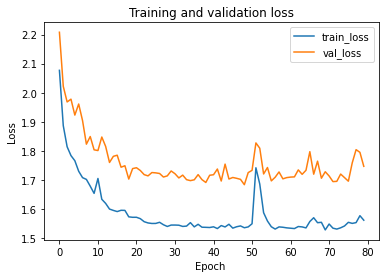

In [15]:
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.title("Training and validation loss")
plt.xlabel("Epoch ")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()

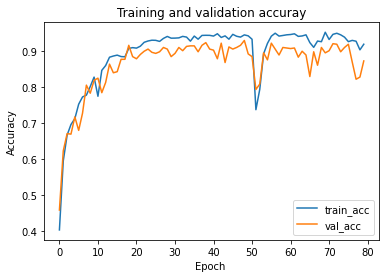

In [16]:
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.title("Training and validation accuray")
plt.xlabel("Epoch ")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

## 4. Evaluate the model

In [17]:
# define the function to evaluate the model
def evaluate(data_loader):
    # forbide the computation of grandient: autograd
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        pred_targets = []
        for data, _ in tqdm(data_loader,  ascii ="  ...="):
            data = data.to(device)
            pred_target = model(data)
            pred_targets.extend(pred_target.argmax(axis=1).cpu().numpy())
    return pred_targets

In [23]:
# display metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
targets_hat = evaluate(test_loader)
print(classification_report(test_data.targets, np.array(targets_hat), target_names=test_data.classes))

100%|==========| 13/13 [00:02<00:00,  4.87it/s]

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.90      0.98      0.94        85
                        Tomato___Early_blight       0.70      0.88      0.78        81
                         Tomato___Late_blight       0.91      0.51      0.65        83
                           Tomato___Leaf_Mold       0.89      0.73      0.80        74
                  Tomato___Septoria_leaf_spot       0.75      0.88      0.81        86
Tomato___Spider_mites Two-spotted_spider_mite       0.65      0.93      0.76        83
                         Tomato___Target_Spot       0.00      0.00      0.00        77
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.88      0.95      0.91        77
                 Tomato___Tomato_mosaic_virus       0.91      0.96      0.93        81
                             Tomato___healthy       0.66      0.96      0.78        79

                                     accu


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

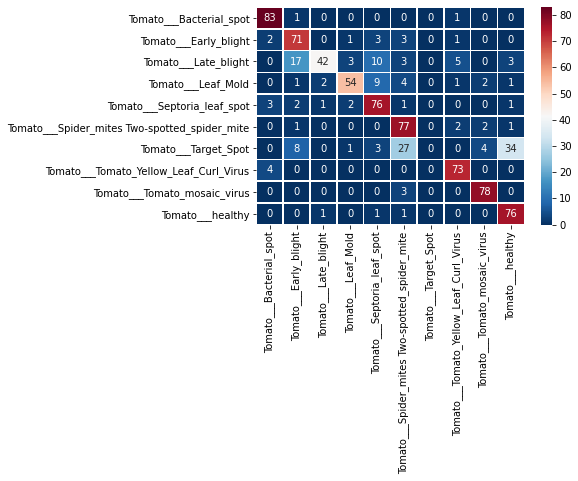

In [27]:
sns.heatmap(confusion_matrix(test_data.targets, targets_hat), 
             xticklabels=test_data.classes,
             yticklabels=test_data.classes,
             cmap='RdBu_r',
             annot=True,
             linewidth=0.5)
